# Equity Market Crisis Regime Prediction using Machine Learning GBDT

## Part IV: Feature Selection, Hyperparameter Tuning

### Quick access to the whole series:

1. [Part I: Introduction](https://www.kaggle.com/code/xxxxyyyy80008/equity-market-crisis-regime-prediction-using-gbdt1)
1. [Part II: Data Preparation](https://www.kaggle.com/code/xxxxyyyy80008/equity-market-crisis-regime-prediction-using-gbdt2)
1. [Part III: Exploratory data analysis](https://www.kaggle.com/code/xxxxyyyy80008/equity-market-crisis-regime-prediction-using-gbdt3)
1. [Part IV: Feature Selection, Hyperparameter Tuning (LightGBM)](https://www.kaggle.com/code/xxxxyyyy80008/equity-market-crisis-regime-prediction-using-gbdt4)
1. [Part V: Model Evaluation and Interpretation (LightGBM)](https://www.kaggle.com/code/xxxxyyyy80008/equity-market-crisis-regime-prediction-using-gbdt5)
1. [Part VI: SVM and Neural Networks (MLP and 1D-CNN)](https://www.kaggle.com/code/xxxxyyyy80008/equity-market-crisis-regime-prediction-using-gbdt6)
1. [Part VII: Compare GBDT Models: XGBoost and LightGBM](https://www.kaggle.com/code/xxxxyyyy80008/equity-market-crisis-regime-prediction-using-gbdt7)
1. [Part VIII: Deployment: end-to-end process (LightGBM)](https://www.kaggle.com/code/xxxxyyyy80008/equity-market-crisis-regime-prediction-using-gbdt8)

---


### Outline of this notebook

<a id="toc"></a>


[1. Load data](#1)

[2. Create 5-fold expanding windows](#2)

[3. Define hyperparameter search space](#3)

[4. Hyperparameter Tuning with hyperopt - TPE Search](#4)

[5. Calculate aggregated feature importance score](#5)

[6. Remove colinear features by VIF (Variance Inflation Factor)](#6)

[7. Train LightGBM models using final feats](#7)




## Load and install packages

In [1]:
import pandas as pd
import numpy as np
import os
import gc
import copy
import json
from pathlib import Path
from datetime import datetime, timedelta, date
import time
from dateutil.relativedelta import relativedelta 

import pyarrow.parquet as pq
import pyarrow as pa

from tqdm import tqdm


In [2]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

pd.options.display.float_format = '{:,.2f}'.format

import warnings
warnings.filterwarnings("ignore")

import pytorch_lightning as pl
random_seed=1
pl.seed_everything(random_seed)

1

<a id="1"></a>

# <left>1. Load data</left>

[back to top](#toc)

In [3]:
df = pd.read_parquet('../input/equity-market-crisis-regime-prediction-using-gbdt2/data.parquet')
df.set_index(keys=['x_date'], inplace=True)

In [4]:
target_cols = ['pct_chg15', 'regime_change', 'target']
feats = set(df.columns)-set(target_cols)

In [5]:
len(feats)

3776

In [6]:
df.replace([-np.inf, np.inf], np.nan, inplace=True)
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

In [7]:
df.isna().sum()[df.isna().sum()>0]

Series([], dtype: int64)

<a id="2"></a>

# <left>2. Create 5-fold expanding windows</left>

[back to top](#toc)

In [8]:
train_start, train_end =  '2002-01-01',  '2019-12-01'
test_sart, test_end = '2020-01-01', '2022-09-10'

In [9]:
train_df = df[(df.index>=train_start) & (df.index<=train_end)]
test_df = df[(df.index>=test_sart) & (df.index<=test_end)]

train_df.shape,  test_df.shape

((4510, 3779), (708, 3779))

In [10]:
kfold_list = []

for yr in [2011, 2013, 2015, 2017, 2019]:
    train_loc = (train_df.index<=f'{yr-2}-12-01') 
    test_loc = (train_df.index<=f'{yr}-12-01') & (train_df.index>f'{yr-1}-01-01')
    kfold_list.append([train_df.loc[train_loc, feats], train_df.loc[train_loc, 'target'],
                       train_df.loc[test_loc, feats], train_df.loc[test_loc, ['target']],
                      ]
                     )
    
for i, (a, b, c, d) in enumerate(kfold_list):
    print(i+1, a.shape, b.shape, c.shape, d.shape, a.index.min(), a.index.max(), c.index.min(), c.index.max())

1 (1994, 3776) (1994,) (484, 3776) (484, 1) 2002-01-02 00:00:00 2009-12-01 00:00:00 2010-01-04 00:00:00 2011-12-01 00:00:00
2 (2499, 3776) (2499,) (481, 3776) (481, 1) 2002-01-02 00:00:00 2011-12-01 00:00:00 2012-01-03 00:00:00 2013-11-29 00:00:00
3 (3000, 3776) (3000,) (483, 3776) (483, 1) 2002-01-02 00:00:00 2013-11-29 00:00:00 2014-01-02 00:00:00 2015-12-01 00:00:00
4 (3504, 3776) (3504,) (484, 3776) (484, 1) 2002-01-02 00:00:00 2015-12-01 00:00:00 2016-01-04 00:00:00 2017-12-01 00:00:00
5 (4009, 3776) (4009,) (482, 3776) (482, 1) 2002-01-02 00:00:00 2017-12-01 00:00:00 2018-01-02 00:00:00 2019-11-29 00:00:00


<a id="3"></a>

# <left>3. Define hyperparameter search space </left>

[back to top](#toc)

In [11]:
from hyperopt import hp
import numpy as np

search_space = {     
                 'num_boost_round': hp.choice('num_boost_round',list(range(650, 1001, 10))),
                 'boosting':hp.choice('boosting', ['gbdt']),
                 'objective':hp.choice('objective', ['binary'] ),
                 'metric':hp.choice('metric', ['auc']),
                 'scale_pos_weight':hp.choice('scale_pos_weight', [20]),
                 'learning_rate':  hp.choice('learning_rate', np.round(np.arange(0.01, 0.76, 0.01),3)), 
                 'feature_fraction': hp.choice('feature_fraction', np.round(np.arange(0.4, 0.86, 0.1),3)), 
                 'max_depth': hp.choice('max_depth', range(1, 3, 1)), #int type
                 'min_data_in_leaf': hp.choice('min_data_in_leaf',range(10, 101, 5)), #int type
                 'lambda_l1':hp.choice('lambda_l1', np.round(np.arange(0.165, 2.005, 0.001),3)),#reg_alpha
                 'lambda_l2':hp.choice('lambda_l2', np.round(np.arange(0.165, 1.005, 0.001),3)),#reg_lambda
                 'max_bin':hp.choice('max_bin', range(100, 501, 1)),#'max_bin':hp.quniform('max_bin', 100, 500, 50),#int
                 #'min_data_in_bin':hp.choice('min_data_in_bin', range(3, 100, 1)),
                 'min_sum_hessian_in_leaf':hp.choice('min_sum_hessian_in_leaf', np.round(np.arange(0.1, 1.25, 0.01),3)), 
                 'min_gain_to_split':hp.choice('min_gain_to_split', np.round(np.arange(0.01, 0.5, 0.01),3)), 
                 'bagging_fraction':hp.choice('bagging_fraction', np.round(np.arange(0.425, 0.65, 0.01),3)), 
                 'bagging_freq':hp.choice('bagging_freq', range(1, 20, 1)), #must be non-zero to use bagging_fraction
                 'seed':hp.choice('seed', [1]), 
    
                  }
                  

In [12]:
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import json

def get_tree_preds(X_train, y_train, X_test, params,
                   num_round=2000, cust_eval=None):

    dtrain = lgb.Dataset(X_train, y_train)
    params['verbosity'] = -1
    i_model = lgb.train(params = params,
                        train_set = dtrain,
                        num_boost_round=num_round,
                        feval=cust_eval,
                        early_stopping_rounds=None)

    y_preds = i_model.predict(X_test, num_iteration=i_model.best_iteration)
    scores = i_model.feature_importance(importance_type='gain', iteration=i_model.best_iteration)
    df_scores = pd.DataFrame({'feature':list(X_train.columns), 'gain': list(scores)})

    return y_preds, df_scores, i_model




In [13]:
from sklearn.metrics import roc_auc_score

def score(params):
   
    num_boost_round = params['num_boost_round']
    #params['metric'] = 'auc'
    
    if params in all_params:
        return {'loss': 99999999, 'status': STATUS_OK}
    
    all_params.append(copy.deepcopy(params))
    
    del params['num_boost_round']
    
    
    i = len(all_params)
    pred_list = []
    
    for j, (X_train, y_train, X_test, y_test) in enumerate(kfold_list):
        y_preds, df_scores, i_model = get_tree_preds(X_train, y_train, X_test, params=params,
                                                       num_round=num_boost_round, 
                                                       cust_eval=None)
        df_pred = y_test.copy(deep=True)

        df_pred['pred'] = y_preds
        df_pred['slide'] = j+1
        pred_list.append(df_pred)
        
    df_pred_all = pd.concat(pred_list, axis=0)
    loss = roc_auc_score(df_pred_all['target'], df_pred_all['pred'])
    loss = -np.round(loss, 3)
    

    i = i + 1
    
    return {'loss': loss, 'status': STATUS_OK}



<a id="4"></a>

# <left>4. Hyperparameter Tuning with hyperopt - TPE Search</left>

[back to top](#toc)

In [14]:
from hyperopt import hp
from hyperopt import space_eval
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, anneal, rand
from functools import partial
def optimize(space, evals, cores, trials, optimizer=tpe.suggest, random_state=1234, n_startup_jobs=10):
    algo = partial(optimizer, n_startup_jobs=n_startup_jobs)
    best = fmin(score, space, algo=algo, max_evals=evals, trials = trials)
    best = space_eval(space, best)
    print(best)
    return best

In [15]:
iter_dict = {}
cores = 8
n_trials = 50
n_random_trials = 20
verbose = False
n_iters = 5
for iter_i in range(n_iters):
    print(datetime.now(), iter_i)
    trials = Trials()
    all_params = []   
    
    best_param = optimize(search_space,
                          evals = n_trials,
                          optimizer=tpe.suggest,
                          cores = cores,
                          trials = trials, random_state=1234, 
                          n_startup_jobs=n_random_trials)    
    
    params = copy.deepcopy(best_param)
    
    num_boost_round = params['num_boost_round']
    del params['num_boost_round']

    scores = []
    for j, (X_train, y_train, X_test, y_test) in enumerate(kfold_list):
        _, df_scores, _ = get_tree_preds(X_train, y_train, X_test, params=params,
                                                       num_round=num_boost_round, 
                                                       cust_eval=None)
        scores.append(df_scores)
        
    iter_dict[iter_i] = {'params': best_param, 
                         'scores': scores}



2022-10-09 10:22:19.671529 0
100%|██████████| 50/50 [1:05:27<00:00, 78.56s/trial, best loss: -0.94]
{'bagging_fraction': 0.475, 'bagging_freq': 1, 'boosting': 'gbdt', 'feature_fraction': 0.4, 'lambda_l1': 1.648, 'lambda_l2': 0.772, 'learning_rate': 0.02, 'max_bin': 135, 'max_depth': 2, 'metric': 'auc', 'min_data_in_leaf': 95, 'min_gain_to_split': 0.33, 'min_sum_hessian_in_leaf': 0.16, 'num_boost_round': 830, 'objective': 'binary', 'scale_pos_weight': 20, 'seed': 1}
2022-10-09 11:28:56.140406 1
100%|██████████| 50/50 [1:09:41<00:00, 83.63s/trial, best loss: -0.934]
{'bagging_fraction': 0.465, 'bagging_freq': 8, 'boosting': 'gbdt', 'feature_fraction': 0.7, 'lambda_l1': 1.176, 'lambda_l2': 0.74, 'learning_rate': 0.02, 'max_bin': 338, 'max_depth': 2, 'metric': 'auc', 'min_data_in_leaf': 55, 'min_gain_to_split': 0.25, 'min_sum_hessian_in_leaf': 0.53, 'num_boost_round': 740, 'objective': 'binary', 'scale_pos_weight': 20, 'seed': 1}
2022-10-09 12:40:42.069491 2
100%|██████████| 50/50 [1:12:07

<a id="5"></a>

# <left>5. Calculate aggregated feature importance score </left>

[back to top](#toc)

In [16]:
scores_dfs = []
for _, v in iter_dict.items():
    scores_ = v['scores']
    tmps = []
    for ss in scores_:
        ss['gain_z'] = (ss['gain'] - ss['gain'].min())/(ss['gain'].quantile(q=0.95)-ss['gain'].quantile(q=0.05))
        tmps.append(ss)
        
    ss = pd.concat(tmps, axis=0)
    ss = ss.groupby('feature')['gain_z'].sum().to_frame()
    display(ss.head(5))
        
    gain_cut = 0.01*ss['gain_z'].sort_values(ascending=False).head(5).mean()
    ss = ss[ss['gain_z']>gain_cut]
    ss.sort_values(by='gain_z', inplace=True)
    ss.reset_index(drop=False, inplace=True)
    ss['rank']=range(ss.shape[0], 0, -1)
    display(ss.tail(5))
    scores_dfs.append(ss)

,gain_z
feature,
AAA10Y,0.10
AAA10Y_chg10,0.71
AAA10Y_chg120,4.47
AAA10Y_chg20,1.00
AAA10Y_chg20_above200dMA,0.00


,feature,gain_z,rank
348,DJI_zscore60,154.28,5
349,GSPC_pct_chg20,188.33,4
350,N100_zscore60,233.52,3
351,WILL5000IND_pct_chg10,271.14,2
352,VIX,442.37,1


,gain_z
feature,
AAA10Y,0.20
AAA10Y_chg10,0.55
AAA10Y_chg120,0.74
AAA10Y_chg20,0.43
AAA10Y_chg20_above200dMA,0.00


,feature,gain_z,rank
283,N100_zscore200,201.81,5
284,GSPC_zscore60,211.37,4
285,VIX,280.89,3
286,FTSE_zscore60,368.81,2
287,WILLLRGCAPVAL_pct_chg10,438.51,1


,gain_z
feature,
AAA10Y,0.00
AAA10Y_chg10,0.00
AAA10Y_chg120,0.00
AAA10Y_chg20,0.43
AAA10Y_chg20_above200dMA,0.00


,feature,gain_z,rank
81,VIX,561.84,5
82,GSPC_zscore200,812.83,4
83,DJI_chg20,816.57,3
84,WILLLRGCAPVAL_pct_chg10,922.53,2
85,WILLLRGCAP_pct_chg10,"1,891.40",1


,gain_z
feature,
AAA10Y,0.21
AAA10Y_chg10,0.78
AAA10Y_chg120,0.66
AAA10Y_chg20,0.28
AAA10Y_chg20_above200dMA,0.00


,feature,gain_z,rank
395,N100_zscore200,141.85,5
396,FTSE_zscore60,155.13,4
397,N100_zscore60,192.32,3
398,WILL5000PR_pct_chg10,252.00,2
399,VIX,364.13,1


,gain_z
feature,
AAA10Y,0.00
AAA10Y_chg10,0.27
AAA10Y_chg120,0.00
AAA10Y_chg20,0.00
AAA10Y_chg20_above200dMA,0.00


,feature,gain_z,rank
244,VIX,270.80,5
245,N100_zscore200,274.55,4
246,GSPC_zscore60,298.51,3
247,WILLLRGCAPVAL_pct_chg10,376.07,2
248,FTSE_zscore60,529.35,1


In [17]:
all_scores = pd.concat(scores_dfs, axis=0)
all_scores.shape

(1376, 3)

In [18]:
all_scores.head(5)

,feature,gain_z,rank
0,LFWA64TTJPM647S_mean_std120,2.58,353
1,TYX_pct_chg5,2.59,352
2,NDX_chg120,2.59,351
3,LFWA64TTJPM647S_zscore250,2.59,350
4,REAINTRATREARAT1YE_std60,2.60,349


<a id="6"></a>

# <left>6. Remove colinear features by VIF (Variance Inflation Factor)</left>

[back to top](#toc)

In [19]:
#reference: https://www.kaggle.com/code/ffisegydd/sklearn-multicollinearity-class
#https://etav.github.io/python/vif_factor_python.html
#https://www.statsmodels.org/dev/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.base import BaseEstimator, TransformerMixin


from statsmodels.stats.outliers_influence import variance_inflation_factor

class ReduceVIF(BaseEstimator, TransformerMixin):
    def __init__(self, thresh=10.0, by_max = False):
        # From looking at documentation, values between 5 and 10 are "okay".
        # Above 10 is too high and so should be removed.
        self.thresh = thresh
        self.by_max = by_max
        
        # The statsmodel function will fail with NaN values, as such we have to impute them.
        # By default we impute using the median value.
        # This imputation could be taken out and added as part of an sklearn Pipeline.
        
        #by_max: if original feature list is sorted by feature importance and want to keep the most important features
        #then set by_max = False
        #by_max = True means remove the max VIF and may not keep the most important features
   

    def fit(self, X):
        print('ReduceVIF fit')

        return self

    def transform(self, X):
        print('ReduceVIF transform')
        columns = X.columns.tolist()

        return ReduceVIF.calculate_vif(X, self.thresh, self.by_max)

    @staticmethod
    def calculate_vif(X, thresh=5.0, by_max = False):
        # Taken from https://stats.stackexchange.com/a/253620/53565 and modified
        dropped=True
        while dropped:
            variables = X.columns
            dropped = False
            vif = [variance_inflation_factor(X[variables].values, X.columns.get_loc(var)) for var in X.columns]
            vif = np.array(vif)
            max_vif = max(vif)
            if max_vif > thresh:
                if by_max:
                    maxloc = list(vif).index(max_vif)
                else:
                    maxloc = list(vif).index(vif[vif>thresh][0])
                print(f'Dropping {X.columns[maxloc]} with vif={max_vif}')
                X = X.drop([X.columns.tolist()[maxloc]], axis=1)
                dropped=True
        return X

### select features by gain_z (min-max scaled) mean


In [20]:
ps = pd.pivot_table(all_scores, 
               index='feature', 
               values=['gain_z'], 
               aggfunc={'gain_z':[np.mean, np.size],
                       }
              )
ps

gain_z     
                       mean size
feature                         
AAA10Y_chg120          4.47    1
AAA10Y_pct_chg10       2.79    2
AAA10Y_pct_chg120      2.71    1
AAA10Y_pct_chg5        5.58    4
AAA10Y_zscore200       8.06    1
...                     ...  ...
WILLSMLCAP_pct_chg10   7.02    4
WILLSMLCAP_std125      2.24    1
WILLSMLCAP_std60       2.62    1
WILLSMLCAP_volat125    4.45    2
WILLSMLCAP_volat60     5.36    2

[654 rows x 2 columns]

In [21]:
ps.describe()

gain_z       
        mean   size
count 654.00 654.00
mean   11.61   2.10
std    35.99   1.28
min     2.22   1.00
25%     3.46   1.00
50%     4.49   2.00
75%     7.49   3.00
max   429.15   5.00

In [22]:
sel_by = (ps[('gain_z', 'size')]>=int(np.floor(5/2))) & (ps[('gain_z', 'mean')]>1)
ps[sel_by].sort_values(by=('gain_z', 'mean'))

gain_z     
                          mean size
feature                            
CPFF_zscore60             2.55    2
CPFF_chg60                2.60    2
TYX_chg20                 2.66    2
AAA10Y_pct_chg10          2.79    2
N225_std60                2.84    2
...                        ...  ...
FTSE_zscore60           233.79    5
WILLLRGCAPVAL_pct_chg10 373.65    5
VIX                     384.01    5
WILLLRGCAP_pct_chg10    393.14    5
GSPC_zscore200          429.15    2

[344 rows x 2 columns]

In [23]:
feat30pct = ps[sel_by].sort_values(by=('gain_z', 'mean')).index.values
len(feat30pct)

344

In [24]:
transformer = ReduceVIF(thresh=10.0, by_max = True)

X = train_df[feat30pct]
X = transformer.fit_transform(X)

print(X.shape)
final_feats = X.columns.tolist()
print(final_feats)
X.head()

ReduceVIF fit
ReduceVIF transform
Dropping WILLLRGCAP_chg10 with vif=25738.147463254412
Dropping WILLLRGCAP_chg20 with vif=15366.22272717871
Dropping WILL5000PRFC_chg10 with vif=9458.954779740394
Dropping WILL5000IND_zscore60 with vif=8391.44031597579
Dropping WILL5000INDFC_chg20 with vif=4836.445451278564
Dropping VIXCLS with vif=4137.053631782205
Dropping WILL5000INDFC_volat60 with vif=2747.2015164411987
Dropping WILL5000INDFC_chg10 with vif=2587.4125013789976
Dropping WILL5000PR_volat60 with vif=1868.5926860027964
Dropping WILL5000PR_chg10 with vif=1812.5698969939704
Dropping WILL5000IND_pct_chg10 with vif=1452.5629886161485
Dropping WILLLRGCAP_zscore60 with vif=1379.897866218285
Dropping MYAGM2JPM189S_zscore250 with vif=1142.2600048243899
Dropping VIXCLS_volat60 with vif=1133.347172676388
Dropping WILLLRGCAPVAL_volat125 with vif=949.178516976281
Dropping GSPC_volat60 with vif=1175.815386544381
Dropping NFCI with vif=925.036634744942
Dropping WILL5000PR_pct_chg10 with vif=848.640050

,CPFF_zscore60,CPFF_chg60,TYX_chg20,AAA10Y_pct_chg10,BAMLEMCBPITRIV_pct_chg10,GC=F_pct_chg5,OVXCLS_pct_chg5,VXNCLS_zscore120,NFCI_pct_chg5,IRLTLT01JPM156N_chg60,AAAFF_chg5,FVX_std60_chg200,T10YIEM_zscore120,T3MFF_chg5,NFCICREDIT_pct_chg10,BAMLCC0A4BBBTRIV_chg5,T10Y3M_chg250,T10YFF_pct_chg10,EEM_mean_std120,NDX_pct_chg5,N100_pct_chg5,ANFCI_ma_dist20_50,ABCOMP_ma_dist500_250,MANMM101JPM189S_std125_chg200,N225_pct_chg10,NIKKEI225_zscore60,T5YFF_chg5,T5YIFR_pct_chg5,DJI_ma_dist20_50,ABCOMP_zscore120,CFNAIDIFF_ma_dist20_50,VXNCLS_std60_chg200,JPY=X_pct_chg5,T5YIFR_zscore60,KLSE_zscore60,BAMLCC0A1AAATRIV_chg20,T3MFF_pct_chg5,T10Y2Y_pct_chg120,NASDAQ100_chg10,USSLIND_pct_chg120,IRSTCI01JPM156N_pct_chg10,CL=F_zscore120,T10YFF_chg10,BAA10YM_zscore120,WILLREITIND_pct_chg20,UMCSENT_std60,WILLREITIND_chg10,WILLLRGCAPVAL_std60_chg200,FVX_chg20,VXDCLS_pct_chg20,...,HSI_zscore60,WILLSMLCAP_pct_chg10,GC=F_chg10,ABCOMP_zscore60,GC=F_chg5,DX-Y.NYB_std125_chg200,JPNASSETS_zscore60,KS11_std60_chg200,T10YFFM_zscore60,VIX_zscore60,NDX_chg120,GC=F_chg20,NASDAQCOM_pct_chg5,CPFF_chg5,VXNCLS_chg5,STLPPM_chg5,T1YFF_pct_chg250,T10Y3MM_pct_chg5,KS11_pct_chg5,T3MFF_zscore60,CPFF_pct_chg10,T10YIEM_pct_chg60,ABCOMP_pct_chg5,EXPINF1YR_chg5_above200dMA,N225_std60_chg200,DX-Y.NYB_zscore60,ABCOMP_chg5,WILLREITIND_ma_dist20_50,REAINTRATREARAT1MO_ma_dist500_250,STLFSI3_chg5,HSI_chg10,MYAGM2JPM189S_chg5,VIX_chg10,RUT_chg10,NFCILEVERAGE_pct_chg10,IRLTLT01JPM156N_ma_dist200_50,JPY=X_pct_chg120,EEM_chg20,T3MFF_chg10,NFCI_chg5,FTSE_chg20,FVX_pct_chg5,USSLIND_pct_chg20,FVX_ma_dist20_50,GVZCLS_chg5,T10Y2YM_std125_chg200,T10YFF_pct_chg20,CPFF_pct_chg20,N100_zscore60,DJI_chg20
x_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2002-01-02,2.34,0.13,0.31,-0.05,-0.00,0.00,0.00,-1.70,-0.08,-0.01,0.24,0.21,-1.00,0.32,0.10,0.21,4.07,0.09,0.00,0.02,0.01,0.04,-12.46,"3,804,127,559,680.00",0.02,0.13,0.23,0.00,228.02,1.52,0.01,2.61,0.02,-1.00,1.71,-3.77,-3.20,0.66,15.46,-2.23,0.00,-0.67,0.28,-0.25,0.03,4.20,34.26,139.16,0.47,-0.09,...,0.77,0.05,1.20,1.58,0.90,-0.61,0.10,28.45,2.91,-1.11,-58.20,2.00,0.02,0.25,-3.85,-0.08,-1.51,0.23,0.12,2.74,-3.17,0.00,0.00,0.00,-348.57,0.16,2.28,58.00,0.52,0.11,-114.93,"837,700,026,368.00",-1.55,7.25,-0.09,-0.05,0.05,0.00,0.39,0.02,53.70,0.00,3.00,0.30,0.00,0.03,0.31,-3.60,0.97,309.44
2002-01-03,2.21,0.36,0.33,-0.01,0.00,-0.01,0.00,-1.29,-0.02,-0.01,0.27,0.21,-1.00,0.18,0.10,0.39,4.20,0.06,0.00,0.05,0.03,0.04,-12.60,"3,826,323,816,448.00",0.01,0.11,0.05,0.00,226.03,1.24,0.01,2.46,0.00,-1.00,1.66,-4.43,4.50,0.58,-29.95,-2.23,0.00,-0.84,0.19,-0.26,0.03,4.11,20.97,131.61,0.48,-0.17,...,0.86,0.02,-2.20,0.89,-1.50,-0.63,0.12,28.78,2.70,-1.39,-30.39,2.80,0.02,0.15,-1.36,-0.08,-1.54,0.23,0.11,2.54,-3.36,0.00,-0.00,0.00,-356.23,0.42,-2.20,58.26,0.53,-0.08,-63.41,"837,700,026,368.00",-1.95,10.02,-0.09,-0.05,0.05,0.00,0.37,0.01,106.70,-0.02,3.00,0.31,0.00,0.03,0.31,-2.73,1.59,278.30
2002-01-04,-0.28,-0.08,0.20,0.03,-0.00,0.01,0.00,-1.49,-0.02,-0.01,0.27,0.21,-1.00,-0.22,0.06,2.45,4.17,-0.02,0.00,0.04,0.01,0.05,-12.75,"3,842,628,386,816.00",0.04,1.51,-0.21,0.00,214.91,1.22,0.00,2.42,-0.01,-1.00,1.91,-4.72,-5.50,0.61,8.98,-2.23,0.00,-0.46,-0.05,-0.27,0.03,4.02,32.30,95.35,0.21,-0.17,...,1.27,0.02,3.40,0.87,1.50,-0.67,2.10,30.05,2.52,-1.56,50.08,5.20,0.04,-0.27,-1.74,-0.08,-5.00,0.23,0.12,0.10,0.23,0.00,-0.01,0.00,-363.89,0.59,-4.48,57.17,0.54,-0.19,136.92,"837,700,026,368.00",-2.13,17.23,-0.06,-0.05,0.05,0.00,0.01,0.01,-9.70,0.00,3.00,0.31,0.00,0.03,0.21,0.07,1.53,145.45
2002-01-07,0.95,0.13,0.03,-0.01,-0.00,0.01,0.00,-1.57,-0.02,-0.01,-0.04,0.21,-1.00,0.15,0.06,0.92,4.41,-0.00,0.00,0.02,-0.01,0.05,-12.90,"3,855,138,160,640.00",0.05,1.80,0.10,0.00,202.78,1.20,-0.00,2.40,0.00,-1.00,1.93,-1.41,-1.07,0.60,46.34,-2.23,0.00,-0.49,-0.01,-0.28,0.02,3.92,37.35,79.40,-0.01,-0.18,...,1.52,0.04,2.60,0.86,2.10,-0.70,2.04,30.92,2.36,-1.16,8.27,4.40,0.04,0.13,-0.81,-0.08,-6.78,0.23,0.08,1.22,-0.50,0.00,-0.01,0.00,-369.

<a id="7"></a>

# <left>7. Train LightGBM models using final feats</left>

[back to top](#toc)

In [25]:
print(final_feats)

['CPFF_zscore60', 'CPFF_chg60', 'TYX_chg20', 'AAA10Y_pct_chg10', 'BAMLEMCBPITRIV_pct_chg10', 'GC=F_pct_chg5', 'OVXCLS_pct_chg5', 'VXNCLS_zscore120', 'NFCI_pct_chg5', 'IRLTLT01JPM156N_chg60', 'AAAFF_chg5', 'FVX_std60_chg200', 'T10YIEM_zscore120', 'T3MFF_chg5', 'NFCICREDIT_pct_chg10', 'BAMLCC0A4BBBTRIV_chg5', 'T10Y3M_chg250', 'T10YFF_pct_chg10', 'EEM_mean_std120', 'NDX_pct_chg5', 'N100_pct_chg5', 'ANFCI_ma_dist20_50', 'ABCOMP_ma_dist500_250', 'MANMM101JPM189S_std125_chg200', 'N225_pct_chg10', 'NIKKEI225_zscore60', 'T5YFF_chg5', 'T5YIFR_pct_chg5', 'DJI_ma_dist20_50', 'ABCOMP_zscore120', 'CFNAIDIFF_ma_dist20_50', 'VXNCLS_std60_chg200', 'JPY=X_pct_chg5', 'T5YIFR_zscore60', 'KLSE_zscore60', 'BAMLCC0A1AAATRIV_chg20', 'T3MFF_pct_chg5', 'T10Y2Y_pct_chg120', 'NASDAQ100_chg10', 'USSLIND_pct_chg120', 'IRSTCI01JPM156N_pct_chg10', 'CL=F_zscore120', 'T10YFF_chg10', 'BAA10YM_zscore120', 'WILLREITIND_pct_chg20', 'UMCSENT_std60', 'WILLREITIND_chg10', 'WILLLRGCAPVAL_std60_chg200', 'FVX_chg20', 'VXDCLS_pc

In [26]:
#final_feats = ['T1YFF_pct_chg60', 'LRUN64TTJPM156S_pct_chg250', 'AAA10Y_chg10', 'T10Y2Y_pct_chg10', 'STOXX50E_chg10', 'BAMLHE00EHYITRIV_pct_chg10', 'T10YFFM_pct_chg10', 'STLFSI3_chg10', 'VIX_chg10', 'JPY=X_pct_chg10', 'IRLTLT01JPM156N_ma_dist20_50', 'NASDAQ100_zscore60', 'KS11_pct_chg10', 'CL=F_pct_chg10', 'T1YFF_pct_chg10', 'CFNAIMA3_ma_dist20_50', 'BAAFFM_zscore60', 'T10Y2YM_zscore250', 'DJI_ma_dist20_50', 'NFCI_zscore60', 'WILLREITIND_zscore60', 'NIKKEI225_zscore60', 'TENEXPCHAREARISPRE_chg250', 'JTSOSL_zscore60', 'CPFF_pct_chg250', 'VIX_pct_chg60', 'COMPOUT_ma_dist20_50', 'STLFSI3_pct_chg10', 'IXIC_ma_dist20_50', 'WILLREITIND_chg10', 'KLSE_zscore60', 'VXDCLS_chg250', 'STLFSI3_zscore250', 'RUT_zscore60', 'LRUN64TTJPM156S_ma_dist20_50', 'UMCSENT_zscore60', 'TENEXPCHAREARISPRE_zscore60', 'GC=F_zscore60', 'JTSOSL_ma_dist20_50', 'RVXCLS_chg10', 'VIXCLS_zscore60', 'NFCIRISK_zscore60', 'T5YIE_pct_chg10', 'AAAFF_pct_chg10', 'T10YFF_pct_chg60', 'ANFCI_pct_chg10', 'ABCOMP_ma_dist20_50', 'IRLTLT01JPM156N_ma_dist200_50', 'VXNCLS_chg10', 'T1YFF_chg10', 'T10Y2Y_chg10', 'NFCIRISK_pct_chg60', 'MANMM101JPM189S_zscore60', 'STLPPMDEF_zscore60', 'CPFF_pct_chg60', 'STLPPM_ma_dist20_50', 'NFCICREDIT_pct_chg10', 'RBJPBIS_chg10', 'JTSOSL_zscore250', 'NFCICREDIT_chg10', 'IRSTCI01JPM156N_zscore60', 'KS11_pct_chg60', 'CFNAI_zscore60', 'T10YIEM_chg60', 'ANFCI_zscore60', 'MYAGM2JPM189S_ma_dist200_50', 'T10Y2YM_pct_chg250', 'KLSE_ma_dist20_50', 'CFNAIDIFF_ma_dist20_50', 'BAMLHYH0A3CMTRIV_pct_chg10', 'KS11_ma_dist20_50', 'BAMLCC0A1AAATRIV_zscore60', 'GC=F_pct_chg10', 'VXNCLS_zscore250', 'STLFSI3_pct_chg60', 'T10YIEM_pct_chg60', 'N100_zscore250', 'TYX_ma_dist200_50', 'NFCI_pct_chg10', 'NASDAQCOM_pct_chg10', 'PAYNSA_chg60', 'IRX_chg10', 'CFNAI_ma_dist20_50', 'CL=F_zscore60', 'BAAFFM_ma_dist200_50', 'T3MFF_zscore60', 'MICH_ma_dist20_50', 'STLFSI3_zscore60', 'GC=F_chg10', 'WILLREITIND_ma_dist20_50', 'NFCICREDIT_pct_chg60', 'KLSE_pct_chg10', 'PAYNSA_ma_dist20_50', 'RBJPBIS_zscore60', 'HSI_chg10', 'AAAFF_chg10', 'STLPPMDEF_chg250', 'FVX_pct_chg10', 'FTSE_chg10', 'N225_chg10', 'BAMLHYH0A0HYM2TRIV_chg10', 'JPNASSETS_zscore60', 'JPNCPIALLMINMEI_pct_chg10', 'CPFF_pct_chg10', 'VIX_zscore60', 'BAA10YM_zscore250', 'ABCOMP_zscore60', 'T10Y3M_pct_chg250', 'PAYEMS_zscore250', 'T10Y2YM_chg250', 'NFCILEVERAGE_chg10', 'NFCINONFINLEVERAGE_zscore60', 'HSI_zscore60', 'VXDCLS_pct_chg10', 'JPNCPIALLMINMEI_zscore60', 'DJI_pct_chg10', 'T3MFF_chg10', 'WILLLRGCAPGR_chg10', 'MYAGM2JPM189S_zscore60', 'FVX_ma_dist20_50', 'VXNCLS', 'NFCICREDIT', 'NFCIRISK_chg10', 'FTSE_zscore60']


In [27]:
X_train, y_train = train_df[final_feats], train_df['target']
X_test, y_test = test_df[final_feats], test_df[['target']]



In [28]:
#https://www.kaggle.com/code/gogo827jz/jane-street-supervised-autoencoder-mlp/notebook?scriptVersionId=73762661
# weighted average as per Donate et al.'s formula
# https://doi.org/10.1016/j.neucom.2012.02.053
# [0.0625, 0.0625, 0.125, 0.25, 0.5] for 5 fold
def weighted_average(a):
    w = []
    n = len(a)
    for j in range(1, n + 1):
        j = 2 if j == 1 else j
        w.append(1 / (2**(n + 1 - j)))
    return np.average(a, weights = w)

In [29]:
for iter_i, v in iter_dict.items():
    params = v['params']
    print(params)

{'bagging_fraction': 0.475, 'bagging_freq': 1, 'boosting': 'gbdt', 'feature_fraction': 0.4, 'lambda_l1': 1.648, 'lambda_l2': 0.772, 'learning_rate': 0.02, 'max_bin': 135, 'max_depth': 2, 'metric': 'auc', 'min_data_in_leaf': 95, 'min_gain_to_split': 0.33, 'min_sum_hessian_in_leaf': 0.16, 'num_boost_round': 830, 'objective': 'binary', 'scale_pos_weight': 20, 'seed': 1}
{'bagging_fraction': 0.465, 'bagging_freq': 8, 'boosting': 'gbdt', 'feature_fraction': 0.7, 'lambda_l1': 1.176, 'lambda_l2': 0.74, 'learning_rate': 0.02, 'max_bin': 338, 'max_depth': 2, 'metric': 'auc', 'min_data_in_leaf': 55, 'min_gain_to_split': 0.25, 'min_sum_hessian_in_leaf': 0.53, 'num_boost_round': 740, 'objective': 'binary', 'scale_pos_weight': 20, 'seed': 1}
{'bagging_fraction': 0.645, 'bagging_freq': 14, 'boosting': 'gbdt', 'feature_fraction': 0.8, 'lambda_l1': 1.613, 'lambda_l2': 0.442, 'learning_rate': 0.24, 'max_bin': 378, 'max_depth': 2, 'metric': 'auc', 'min_data_in_leaf': 75, 'min_gain_to_split': 0.11, 'min_

In [30]:
df_pred = y_test.copy(deep=True)
pred_cols  = []
for iter_i, v in iter_dict.items():
    params = copy.deepcopy(v['params'])
    num_boost_round = params['num_boost_round']
    del params['num_boost_round']

    y_preds, df_scores, i_model = get_tree_preds(X_train, y_train, X_test, params=params,
                                                   num_round=num_boost_round, 
                                                   cust_eval=None)
    

    pred_cols.append(f'pred{iter_i}')
    df_pred[f'pred{iter_i}'] = y_preds

<AxesSubplot:xlabel='x_date'>

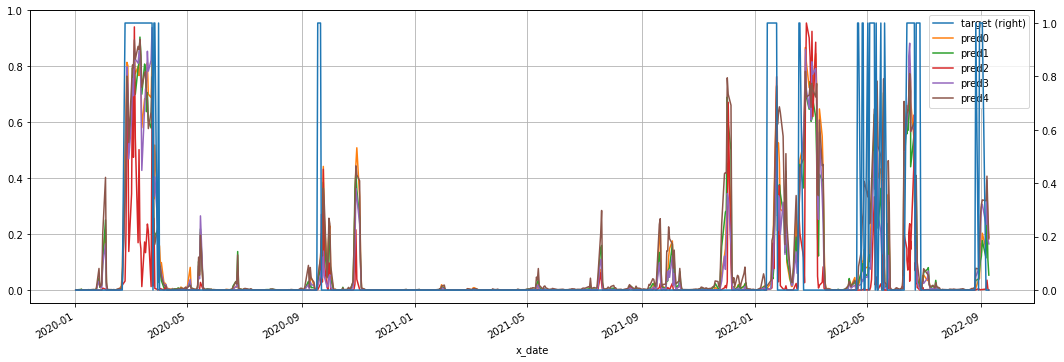

In [31]:
df_pred.plot(figsize=(18, 6), secondary_y=['target'], grid=True)

In [32]:
df_pred['pred_mean']=df_pred[pred_cols].mean(axis=1)
df_pred['pred_mean_label']=((df_pred[pred_cols]>0.5).mean(axis=1)>0.5).astype(int)


<AxesSubplot:xlabel='x_date'>

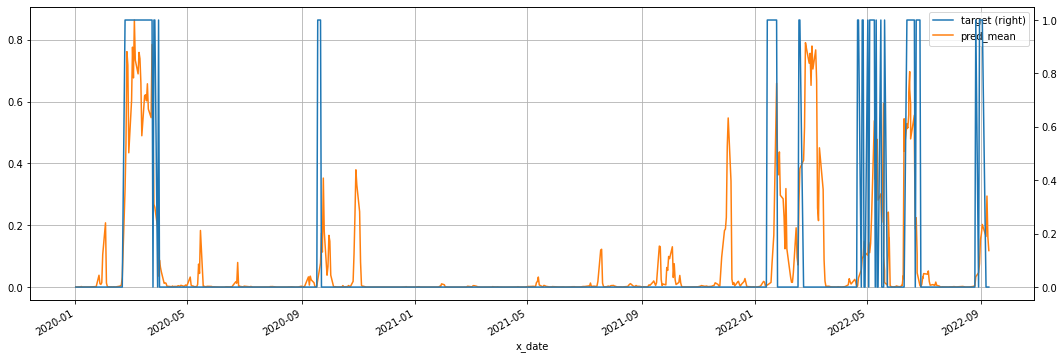

In [33]:
df_pred[['target', 'pred_mean',]].plot(figsize=(18, 6), secondary_y=['target'], grid=True)

<AxesSubplot:xlabel='x_date'>

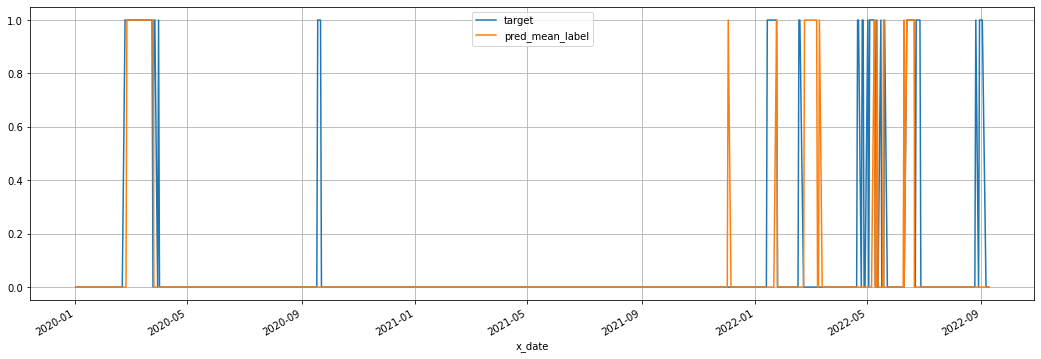

In [34]:
df_pred[['target', 'pred_mean_label']].plot(figsize=(18, 6),  grid=True)

In [35]:
for c in pred_cols + ['pred_mean']:
    auc_score = roc_auc_score(df_pred['target'], df_pred[c])
    print(c, f'{auc_score:.3f}')

pred0 0.923
pred1 0.918
pred2 0.902
pred3 0.927
pred4 0.925
pred_mean 0.925
